## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-11-17 11:04:45--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.12’

train-test-data.zip 100%[===================>] 322.93M  55.0MB/s    in 5.5s    

2020-11-17 11:04:51 (59.1 MB/s) - ‘/data/train-test-data.zip.12’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)



Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.3)
  (drop4): Dropout(p=0.4)
  (drop5): Dropout(p=0.5)
  (drop6): Dropout(p=0.6)
)


In [4]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [9]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        if train_on_gpu:
            images = images.cuda()
            net.cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

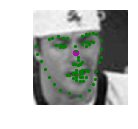

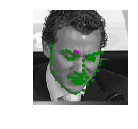

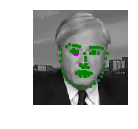

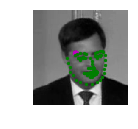

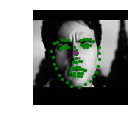

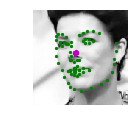

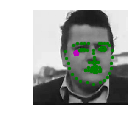

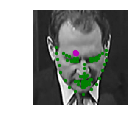

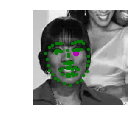

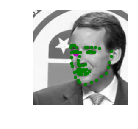

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=batch_size):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        if train_on_gpu:
            image = image.detach().cpu().numpy()
        else:
            image = image.numpy()   # convert to numpy array from a Tensor

        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        if train_on_gpu:
            predicted_key_pts = predicted_key_pts.detach().cpu().numpy()
        else:
            predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [14]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

lr = 0.0001
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
optimizer = optim.Adam(net.parameters(), lr, [beta1, beta2], eps)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    if train_on_gpu:
        net.cuda()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            if train_on_gpu:
                images = images.cuda()
                key_pts = key_pts.cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [16]:
# net.load_state_dict(torch.load('saved_models/keypoints_model.pt'))
# train your network
n_epochs = 40 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.4670803666114807
Epoch: 1, Batch: 20, Avg. Loss: 0.34763377010822294
Epoch: 1, Batch: 30, Avg. Loss: 0.28601555675268175
Epoch: 1, Batch: 40, Avg. Loss: 0.2623753011226654
Epoch: 1, Batch: 50, Avg. Loss: 0.30536256581544874
Epoch: 1, Batch: 60, Avg. Loss: 0.30184735506772997
Epoch: 1, Batch: 70, Avg. Loss: 0.20576467216014863
Epoch: 1, Batch: 80, Avg. Loss: 0.24006982743740082
Epoch: 1, Batch: 90, Avg. Loss: 0.24500400424003602
Epoch: 1, Batch: 100, Avg. Loss: 0.23824477195739746
Epoch: 1, Batch: 110, Avg. Loss: 0.2270601749420166
Epoch: 1, Batch: 120, Avg. Loss: 0.22380032986402512
Epoch: 1, Batch: 130, Avg. Loss: 0.24185930341482162
Epoch: 1, Batch: 140, Avg. Loss: 0.1958850234746933
Epoch: 1, Batch: 150, Avg. Loss: 0.24841981679201125
Epoch: 1, Batch: 160, Avg. Loss: 0.23990341275930405
Epoch: 1, Batch: 170, Avg. Loss: 0.19631360620260238
Epoch: 1, Batch: 180, Avg. Loss: 0.2335154451429844
Epoch: 1, Batch: 190, Avg. Loss: 0.22233280092477797
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.15859789550304412
Epoch: 2, Batch: 20, Avg. Loss: 0.20584740936756135
Epoch: 2, Batch: 30, Avg. Loss: 0.2502278730273247
Epoch: 2, Batch: 40, Avg. Loss: 0.4154902003705502
Epoch: 2, Batch: 50, Avg. Loss: 0.21976483166217803
Epoch: 2, Batch: 60, Avg. Loss: 0.16034945026040076
Epoch: 2, Batch: 70, Avg. Loss: 0.19987108334898948
Epoch: 2, Batch: 80, Avg. Loss: 0.2474476233124733
Epoch: 2, Batch: 90, Avg. Loss: 0.16657104790210725
Epoch: 2, Batch: 100, Avg. Loss: 0.20470995157957078
Epoch: 2, Batch: 110, Avg. Loss: 0.1945110872387886
Epoch: 2, Batch: 120, Avg. Loss: 0.1898559659719467
Epoch: 2, Batch: 130, Avg. Loss: 0.16748793795704842
Epoch: 2, Batch: 140, Avg. Loss: 0.19232203364372252
Epoch: 2, Batch: 150, Avg. Loss: 0.17960280254483224
Epoch: 2, Batch: 160, Avg. Loss: 0.1924824148416519
Epoch: 2, Batch: 170, Avg. Loss: 0.17226431146264076
Epoch: 2, Batch: 180, Avg. Loss: 0.174611459672451
Epoch: 2, Batch: 190, Avg. Loss: 0.23587751090526582
Epoch: 2, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.21600705832242967
Epoch: 3, Batch: 20, Avg. Loss: 0.15241407081484795
Epoch: 3, Batch: 30, Avg. Loss: 0.15772519409656524
Epoch: 3, Batch: 40, Avg. Loss: 0.17466529309749604
Epoch: 3, Batch: 50, Avg. Loss: 0.19040965139865876
Epoch: 3, Batch: 60, Avg. Loss: 0.21750080734491348
Epoch: 3, Batch: 70, Avg. Loss: 0.16028935387730597
Epoch: 3, Batch: 80, Avg. Loss: 0.19543028771877288
Epoch: 3, Batch: 90, Avg. Loss: 0.15721805840730668
Epoch: 3, Batch: 100, Avg. Loss: 0.1744956076145172
Epoch: 3, Batch: 110, Avg. Loss: 0.15161898285150527
Epoch: 3, Batch: 120, Avg. Loss: 0.3307898655533791
Epoch: 3, Batch: 130, Avg. Loss: 0.17762513160705568
Epoch: 3, Batch: 140, Avg. Loss: 0.17121329084038733
Epoch: 3, Batch: 150, Avg. Loss: 0.2184467136859894
Epoch: 3, Batch: 160, Avg. Loss: 0.14841658845543862
Epoch: 3, Batch: 170, Avg. Loss: 0.16168034598231315
Epoch: 3, Batch: 180, Avg. Loss: 0.1398415334522724
Epoch: 3, Batch: 190, Avg. Loss: 0.17087619453668595
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.13876792266964913
Epoch: 4, Batch: 20, Avg. Loss: 0.14537471160292625
Epoch: 4, Batch: 30, Avg. Loss: 0.14815155044198036
Epoch: 4, Batch: 40, Avg. Loss: 0.1504291646182537
Epoch: 4, Batch: 50, Avg. Loss: 0.15493696182966232
Epoch: 4, Batch: 60, Avg. Loss: 0.17038820907473565
Epoch: 4, Batch: 70, Avg. Loss: 0.14155975356698036
Epoch: 4, Batch: 80, Avg. Loss: 0.22332667633891107
Epoch: 4, Batch: 90, Avg. Loss: 0.18706640601158142
Epoch: 4, Batch: 100, Avg. Loss: 0.17084180936217308
Epoch: 4, Batch: 110, Avg. Loss: 0.135367701202631
Epoch: 4, Batch: 120, Avg. Loss: 0.17356804385781288
Epoch: 4, Batch: 130, Avg. Loss: 0.17269134745001793
Epoch: 4, Batch: 140, Avg. Loss: 0.2267850160598755
Epoch: 4, Batch: 150, Avg. Loss: 0.14178053066134452
Epoch: 4, Batch: 160, Avg. Loss: 0.1432692777365446
Epoch: 4, Batch: 170, Avg. Loss: 0.14028246328234673
Epoch: 4, Batch: 180, Avg. Loss: 0.14495566263794898
Epoch: 4, Batch: 190, Avg. Loss: 0.2309717133641243
Epoch: 4

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.1326742760837078
Epoch: 5, Batch: 20, Avg. Loss: 0.145905701816082
Epoch: 5, Batch: 30, Avg. Loss: 0.14561647102236747
Epoch: 5, Batch: 40, Avg. Loss: 0.1456368751823902
Epoch: 5, Batch: 50, Avg. Loss: 0.17145157754421234
Epoch: 5, Batch: 60, Avg. Loss: 0.11428468227386475
Epoch: 5, Batch: 70, Avg. Loss: 0.2787093907594681
Epoch: 5, Batch: 80, Avg. Loss: 0.125748360902071
Epoch: 5, Batch: 90, Avg. Loss: 0.12780655100941657
Epoch: 5, Batch: 100, Avg. Loss: 0.21875110566616057
Epoch: 5, Batch: 110, Avg. Loss: 0.13693196699023247
Epoch: 5, Batch: 120, Avg. Loss: 0.15983985885977745
Epoch: 5, Batch: 130, Avg. Loss: 0.1315460056066513
Epoch: 5, Batch: 140, Avg. Loss: 0.11118012815713882
Epoch: 5, Batch: 150, Avg. Loss: 0.1653233490884304
Epoch: 5, Batch: 160, Avg. Loss: 0.14703934416174888
Epoch: 5, Batch: 170, Avg. Loss: 0.161660023778677
Epoch: 5, Batch: 180, Avg. Loss: 0.14595899134874343
Epoch: 5, Batch: 190, Avg. Loss: 0.12880807220935822
Epoch: 5, Bat

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.11174092963337898
Epoch: 6, Batch: 20, Avg. Loss: 0.16127802133560182
Epoch: 6, Batch: 30, Avg. Loss: 0.15861453711986542
Epoch: 6, Batch: 40, Avg. Loss: 0.1164209172129631
Epoch: 6, Batch: 50, Avg. Loss: 0.1324688635766506
Epoch: 6, Batch: 60, Avg. Loss: 0.1722692921757698
Epoch: 6, Batch: 70, Avg. Loss: 0.14696532785892485
Epoch: 6, Batch: 80, Avg. Loss: 0.13825569078326225
Epoch: 6, Batch: 90, Avg. Loss: 0.12327664643526078
Epoch: 6, Batch: 100, Avg. Loss: 0.12291870713233947
Epoch: 6, Batch: 110, Avg. Loss: 0.1200866498053074
Epoch: 6, Batch: 120, Avg. Loss: 0.14719736874103545
Epoch: 6, Batch: 130, Avg. Loss: 0.10748337619006634
Epoch: 6, Batch: 140, Avg. Loss: 0.1657060980796814
Epoch: 6, Batch: 150, Avg. Loss: 0.10941201150417328
Epoch: 6, Batch: 160, Avg. Loss: 0.11352980732917786
Epoch: 6, Batch: 170, Avg. Loss: 0.10111162886023521
Epoch: 6, Batch: 180, Avg. Loss: 0.11241833306849003
Epoch: 6, Batch: 190, Avg. Loss: 0.256427388638258
Epoch: 6,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.07256386019289493
Epoch: 7, Batch: 20, Avg. Loss: 0.11960602551698685
Epoch: 7, Batch: 30, Avg. Loss: 0.09699463397264481
Epoch: 7, Batch: 40, Avg. Loss: 0.11918483525514603
Epoch: 7, Batch: 50, Avg. Loss: 0.09719181098043919
Epoch: 7, Batch: 60, Avg. Loss: 0.11252899132668973
Epoch: 7, Batch: 70, Avg. Loss: 0.09060739986598491
Epoch: 7, Batch: 80, Avg. Loss: 0.2913779575377703
Epoch: 7, Batch: 90, Avg. Loss: 0.08595546297729015
Epoch: 7, Batch: 100, Avg. Loss: 0.1358385358005762
Epoch: 7, Batch: 110, Avg. Loss: 0.10458727665245533
Epoch: 7, Batch: 120, Avg. Loss: 0.10085994489490986
Epoch: 7, Batch: 130, Avg. Loss: 0.08913125842809677
Epoch: 7, Batch: 140, Avg. Loss: 0.09222369901835918
Epoch: 7, Batch: 150, Avg. Loss: 0.07460403740406037
Epoch: 7, Batch: 160, Avg. Loss: 0.10685374587774277
Epoch: 7, Batch: 170, Avg. Loss: 0.12940460331737996
Epoch: 7, Batch: 180, Avg. Loss: 0.10717180557549
Epoch: 7, Batch: 190, Avg. Loss: 0.08830265179276467
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.07931995093822479
Epoch: 8, Batch: 20, Avg. Loss: 0.10514139160513877
Epoch: 8, Batch: 30, Avg. Loss: 0.07632976211607456
Epoch: 8, Batch: 40, Avg. Loss: 0.1112709753215313
Epoch: 8, Batch: 50, Avg. Loss: 0.10143118500709533
Epoch: 8, Batch: 60, Avg. Loss: 0.08915716297924518
Epoch: 8, Batch: 70, Avg. Loss: 0.07970068082213402
Epoch: 8, Batch: 80, Avg. Loss: 0.06904227547347545
Epoch: 8, Batch: 90, Avg. Loss: 0.08307386487722397
Epoch: 8, Batch: 100, Avg. Loss: 0.0928355947136879
Epoch: 8, Batch: 110, Avg. Loss: 0.08809922151267528
Epoch: 8, Batch: 120, Avg. Loss: 0.1109913520514965
Epoch: 8, Batch: 130, Avg. Loss: 0.08164717070758343
Epoch: 8, Batch: 140, Avg. Loss: 0.07142729945480823
Epoch: 8, Batch: 150, Avg. Loss: 0.08347613774240017
Epoch: 8, Batch: 160, Avg. Loss: 0.08806879073381424
Epoch: 8, Batch: 170, Avg. Loss: 0.08552097640931607
Epoch: 8, Batch: 180, Avg. Loss: 0.08265382908284664
Epoch: 8, Batch: 190, Avg. Loss: 0.07306116260588169
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0662783369421959
Epoch: 9, Batch: 20, Avg. Loss: 0.1430114794522524
Epoch: 9, Batch: 30, Avg. Loss: 0.11260084025561809
Epoch: 9, Batch: 40, Avg. Loss: 0.1279838837683201
Epoch: 9, Batch: 50, Avg. Loss: 0.06360257044434547
Epoch: 9, Batch: 60, Avg. Loss: 0.06590561084449291
Epoch: 9, Batch: 70, Avg. Loss: 0.07045533116906881
Epoch: 9, Batch: 80, Avg. Loss: 0.12301260828971863
Epoch: 9, Batch: 90, Avg. Loss: 0.07866391651332379
Epoch: 9, Batch: 100, Avg. Loss: 0.08300784714519978
Epoch: 9, Batch: 110, Avg. Loss: 0.06002789996564388
Epoch: 9, Batch: 120, Avg. Loss: 0.06549595929682255
Epoch: 9, Batch: 130, Avg. Loss: 0.055260741338133815
Epoch: 9, Batch: 140, Avg. Loss: 0.066117138043046
Epoch: 9, Batch: 150, Avg. Loss: 0.07761324979364873
Epoch: 9, Batch: 160, Avg. Loss: 0.0748968929052353
Epoch: 9, Batch: 170, Avg. Loss: 0.0919889323413372
Epoch: 9, Batch: 180, Avg. Loss: 0.07518678195774556
Epoch: 9, Batch: 190, Avg. Loss: 0.0610498059540987
Epoch: 9,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.06316713280975819
Epoch: 10, Batch: 20, Avg. Loss: 0.054169216006994245
Epoch: 10, Batch: 30, Avg. Loss: 0.12452194392681122
Epoch: 10, Batch: 40, Avg. Loss: 0.05782045163214207
Epoch: 10, Batch: 50, Avg. Loss: 0.08693363219499588
Epoch: 10, Batch: 60, Avg. Loss: 0.09842735268175602
Epoch: 10, Batch: 70, Avg. Loss: 0.07079418376088142
Epoch: 10, Batch: 80, Avg. Loss: 0.060794199258089064
Epoch: 10, Batch: 90, Avg. Loss: 0.0655479036271572
Epoch: 10, Batch: 100, Avg. Loss: 0.1000888217240572
Epoch: 10, Batch: 110, Avg. Loss: 0.07267660908401012
Epoch: 10, Batch: 120, Avg. Loss: 0.06962845101952553
Epoch: 10, Batch: 130, Avg. Loss: 0.1054227590560913
Epoch: 10, Batch: 140, Avg. Loss: 0.07112920843064785
Epoch: 10, Batch: 150, Avg. Loss: 0.11498673185706139
Epoch: 10, Batch: 160, Avg. Loss: 0.07725774422287941
Epoch: 10, Batch: 170, Avg. Loss: 0.06715407334268093
Epoch: 10, Batch: 180, Avg. Loss: 0.07078993991017342
Epoch: 10, Batch: 190, Avg. Loss: 0.08

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.07197781763970852
Epoch: 11, Batch: 20, Avg. Loss: 0.07066252268850803
Epoch: 11, Batch: 30, Avg. Loss: 0.0543971985578537
Epoch: 11, Batch: 40, Avg. Loss: 0.08329811692237854
Epoch: 11, Batch: 50, Avg. Loss: 0.1234171885997057
Epoch: 11, Batch: 60, Avg. Loss: 0.06089719980955124
Epoch: 11, Batch: 70, Avg. Loss: 0.08711541332304477
Epoch: 11, Batch: 80, Avg. Loss: 0.060198139399290085
Epoch: 11, Batch: 90, Avg. Loss: 0.11823772639036179
Epoch: 11, Batch: 100, Avg. Loss: 0.07041127942502498
Epoch: 11, Batch: 110, Avg. Loss: 0.06939644813537597
Epoch: 11, Batch: 120, Avg. Loss: 0.07500888481736183
Epoch: 11, Batch: 130, Avg. Loss: 0.08503221496939659
Epoch: 11, Batch: 140, Avg. Loss: 0.0822352845221758
Epoch: 11, Batch: 150, Avg. Loss: 0.17146623469889163
Epoch: 11, Batch: 160, Avg. Loss: 0.060250142589211464
Epoch: 11, Batch: 170, Avg. Loss: 0.06409998908638954
Epoch: 11, Batch: 180, Avg. Loss: 0.06612315103411674
Epoch: 11, Batch: 190, Avg. Loss: 0.07

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.065336774289608
Epoch: 12, Batch: 20, Avg. Loss: 0.048017000406980516
Epoch: 12, Batch: 30, Avg. Loss: 0.0660738456994295
Epoch: 12, Batch: 40, Avg. Loss: 0.09690682254731656
Epoch: 12, Batch: 50, Avg. Loss: 0.05910025406628847
Epoch: 12, Batch: 60, Avg. Loss: 0.06092662774026394
Epoch: 12, Batch: 70, Avg. Loss: 0.06496975608170033
Epoch: 12, Batch: 80, Avg. Loss: 0.0795734018087387
Epoch: 12, Batch: 90, Avg. Loss: 0.04921688511967659
Epoch: 12, Batch: 100, Avg. Loss: 0.07994994744658471
Epoch: 12, Batch: 110, Avg. Loss: 0.09546511545777321
Epoch: 12, Batch: 120, Avg. Loss: 0.054839428141713144
Epoch: 12, Batch: 130, Avg. Loss: 0.05661094412207603
Epoch: 12, Batch: 140, Avg. Loss: 0.11419060118496419
Epoch: 12, Batch: 150, Avg. Loss: 0.07999338191002607
Epoch: 12, Batch: 160, Avg. Loss: 0.05701324045658111
Epoch: 12, Batch: 170, Avg. Loss: 0.047157660499215125
Epoch: 12, Batch: 180, Avg. Loss: 0.051666695065796374
Epoch: 12, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.12546859979629515
Epoch: 13, Batch: 20, Avg. Loss: 0.04914098046720028
Epoch: 13, Batch: 30, Avg. Loss: 0.09601974077522754
Epoch: 13, Batch: 40, Avg. Loss: 0.19016938395798205
Epoch: 13, Batch: 50, Avg. Loss: 0.048168912157416345
Epoch: 13, Batch: 60, Avg. Loss: 0.05955933500081301
Epoch: 13, Batch: 70, Avg. Loss: 0.0593342412263155
Epoch: 13, Batch: 80, Avg. Loss: 0.059368273988366124
Epoch: 13, Batch: 90, Avg. Loss: 0.05616409480571747
Epoch: 13, Batch: 100, Avg. Loss: 0.05050056353211403
Epoch: 13, Batch: 110, Avg. Loss: 0.04794556964188814
Epoch: 13, Batch: 120, Avg. Loss: 0.05605403333902359
Epoch: 13, Batch: 130, Avg. Loss: 0.07069672346115112
Epoch: 13, Batch: 140, Avg. Loss: 0.0629098080098629
Epoch: 13, Batch: 150, Avg. Loss: 0.04442518595606089
Epoch: 13, Batch: 160, Avg. Loss: 0.10091005377471447
Epoch: 13, Batch: 170, Avg. Loss: 0.060583066381514075
Epoch: 13, Batch: 180, Avg. Loss: 0.06508948821574449
Epoch: 13, Batch: 190, Avg. Loss: 0.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.0588584166020155
Epoch: 14, Batch: 20, Avg. Loss: 0.05749122146517038
Epoch: 14, Batch: 30, Avg. Loss: 0.06384328193962574
Epoch: 14, Batch: 40, Avg. Loss: 0.1307787023484707
Epoch: 14, Batch: 50, Avg. Loss: 0.06989907324314118
Epoch: 14, Batch: 60, Avg. Loss: 0.04912877827882767
Epoch: 14, Batch: 70, Avg. Loss: 0.046780250035226345
Epoch: 14, Batch: 80, Avg. Loss: 0.04159021954983473
Epoch: 14, Batch: 90, Avg. Loss: 0.05120437890291214
Epoch: 14, Batch: 100, Avg. Loss: 0.05304210558533669
Epoch: 14, Batch: 110, Avg. Loss: 0.04700599517673254
Epoch: 14, Batch: 120, Avg. Loss: 0.1303041484206915
Epoch: 14, Batch: 130, Avg. Loss: 0.04399029333144426
Epoch: 14, Batch: 140, Avg. Loss: 0.05777445249259472
Epoch: 14, Batch: 150, Avg. Loss: 0.06629730500280857
Epoch: 14, Batch: 160, Avg. Loss: 0.05000448375940323
Epoch: 14, Batch: 170, Avg. Loss: 0.06818400099873542
Epoch: 14, Batch: 180, Avg. Loss: 0.05466464273631573
Epoch: 14, Batch: 190, Avg. Loss: 0.071

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.040528461895883085
Epoch: 15, Batch: 20, Avg. Loss: 0.04771231189370155
Epoch: 15, Batch: 30, Avg. Loss: 0.05142157021909952
Epoch: 15, Batch: 40, Avg. Loss: 0.06952316910028458
Epoch: 15, Batch: 50, Avg. Loss: 0.04556467719376087
Epoch: 15, Batch: 60, Avg. Loss: 0.044887938909232615
Epoch: 15, Batch: 70, Avg. Loss: 0.05476975925266743
Epoch: 15, Batch: 80, Avg. Loss: 0.059783657640218736
Epoch: 15, Batch: 90, Avg. Loss: 0.06257819905877113
Epoch: 15, Batch: 100, Avg. Loss: 0.038686261512339115
Epoch: 15, Batch: 110, Avg. Loss: 0.05421381294727325
Epoch: 15, Batch: 120, Avg. Loss: 0.048175822012126446
Epoch: 15, Batch: 130, Avg. Loss: 0.04741133749485016
Epoch: 15, Batch: 140, Avg. Loss: 0.04830716587603092
Epoch: 15, Batch: 150, Avg. Loss: 0.05663622617721557
Epoch: 15, Batch: 160, Avg. Loss: 0.05290919691324234
Epoch: 15, Batch: 170, Avg. Loss: 0.056629867479205134
Epoch: 15, Batch: 180, Avg. Loss: 0.053787716291844846
Epoch: 15, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.05112028978765011
Epoch: 16, Batch: 20, Avg. Loss: 0.04237436279654503
Epoch: 16, Batch: 30, Avg. Loss: 0.044231930375099184
Epoch: 16, Batch: 40, Avg. Loss: 0.04322602692991495
Epoch: 16, Batch: 50, Avg. Loss: 0.07345083709806204
Epoch: 16, Batch: 60, Avg. Loss: 0.05025034919381142
Epoch: 16, Batch: 70, Avg. Loss: 0.04198583923280239
Epoch: 16, Batch: 80, Avg. Loss: 0.04496334232389927
Epoch: 16, Batch: 90, Avg. Loss: 0.05072206519544124
Epoch: 16, Batch: 100, Avg. Loss: 0.0930547520518303
Epoch: 16, Batch: 110, Avg. Loss: 0.04361863434314728
Epoch: 16, Batch: 120, Avg. Loss: 0.0754408435896039
Epoch: 16, Batch: 130, Avg. Loss: 0.04542271643877029
Epoch: 16, Batch: 140, Avg. Loss: 0.0428387314081192
Epoch: 16, Batch: 150, Avg. Loss: 0.04557156562805176
Epoch: 16, Batch: 160, Avg. Loss: 0.054696868360042575
Epoch: 16, Batch: 170, Avg. Loss: 0.05002506952732801
Epoch: 16, Batch: 180, Avg. Loss: 0.049855169653892514
Epoch: 16, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.047270702198147774
Epoch: 17, Batch: 20, Avg. Loss: 0.05603672992438078
Epoch: 17, Batch: 30, Avg. Loss: 0.04537203311920166
Epoch: 17, Batch: 40, Avg. Loss: 0.054071559384465215
Epoch: 17, Batch: 50, Avg. Loss: 0.05442485082894564
Epoch: 17, Batch: 60, Avg. Loss: 0.042139926739037034
Epoch: 17, Batch: 70, Avg. Loss: 0.0442047918215394
Epoch: 17, Batch: 80, Avg. Loss: 0.037677067518234256
Epoch: 17, Batch: 90, Avg. Loss: 0.05347647070884705
Epoch: 17, Batch: 100, Avg. Loss: 0.05257672481238842
Epoch: 17, Batch: 110, Avg. Loss: 0.04368570595979691
Epoch: 17, Batch: 120, Avg. Loss: 0.08139928542077542
Epoch: 17, Batch: 130, Avg. Loss: 0.09203169606626034
Epoch: 17, Batch: 140, Avg. Loss: 0.2194007646292448
Epoch: 17, Batch: 150, Avg. Loss: 0.041567712277174
Epoch: 17, Batch: 160, Avg. Loss: 0.048910847119987014
Epoch: 17, Batch: 170, Avg. Loss: 0.0363585639744997
Epoch: 17, Batch: 180, Avg. Loss: 0.03594156708568334
Epoch: 17, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.22988127674907446
Epoch: 18, Batch: 20, Avg. Loss: 0.05220075994729996
Epoch: 18, Batch: 30, Avg. Loss: 0.0538764763623476
Epoch: 18, Batch: 40, Avg. Loss: 0.0709914218634367
Epoch: 18, Batch: 50, Avg. Loss: 0.045593146793544294
Epoch: 18, Batch: 60, Avg. Loss: 0.05156451612710953
Epoch: 18, Batch: 70, Avg. Loss: 0.044948454946279526
Epoch: 18, Batch: 80, Avg. Loss: 0.046117371320724486
Epoch: 18, Batch: 90, Avg. Loss: 0.045662338472902776
Epoch: 18, Batch: 100, Avg. Loss: 0.050817526131868365
Epoch: 18, Batch: 110, Avg. Loss: 0.041306708753108975
Epoch: 18, Batch: 120, Avg. Loss: 0.03768177106976509
Epoch: 18, Batch: 130, Avg. Loss: 0.04997457675635815
Epoch: 18, Batch: 140, Avg. Loss: 0.04283512532711029
Epoch: 18, Batch: 150, Avg. Loss: 0.04411173705011606
Epoch: 18, Batch: 160, Avg. Loss: 0.03734227605164051
Epoch: 18, Batch: 170, Avg. Loss: 0.05204148013144731
Epoch: 18, Batch: 180, Avg. Loss: 0.04152253065258264
Epoch: 18, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.04288596492260695
Epoch: 19, Batch: 20, Avg. Loss: 0.06141952276229858
Epoch: 19, Batch: 30, Avg. Loss: 0.06607278902083635
Epoch: 19, Batch: 40, Avg. Loss: 0.10045691765844822
Epoch: 19, Batch: 50, Avg. Loss: 0.04401448033750057
Epoch: 19, Batch: 60, Avg. Loss: 0.05920588802546263
Epoch: 19, Batch: 70, Avg. Loss: 0.042917984165251256
Epoch: 19, Batch: 80, Avg. Loss: 0.04216753151267767
Epoch: 19, Batch: 90, Avg. Loss: 0.03686133474111557
Epoch: 19, Batch: 100, Avg. Loss: 0.07084249146282673
Epoch: 19, Batch: 110, Avg. Loss: 0.049137574061751364
Epoch: 19, Batch: 120, Avg. Loss: 0.03663159478455782
Epoch: 19, Batch: 130, Avg. Loss: 0.043857765197753903
Epoch: 19, Batch: 140, Avg. Loss: 0.06249916795641184
Epoch: 19, Batch: 150, Avg. Loss: 0.0425539992749691
Epoch: 19, Batch: 160, Avg. Loss: 0.040094094537198546
Epoch: 19, Batch: 170, Avg. Loss: 0.035449230670928956
Epoch: 19, Batch: 180, Avg. Loss: 0.04250390343368053
Epoch: 19, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.059337719529867175
Epoch: 20, Batch: 20, Avg. Loss: 0.038419040851294994
Epoch: 20, Batch: 30, Avg. Loss: 0.03834088966250419
Epoch: 20, Batch: 40, Avg. Loss: 0.03275590166449547
Epoch: 20, Batch: 50, Avg. Loss: 0.04841443728655577
Epoch: 20, Batch: 60, Avg. Loss: 0.11828643884509801
Epoch: 20, Batch: 70, Avg. Loss: 0.04701681472361088
Epoch: 20, Batch: 80, Avg. Loss: 0.04437943063676357
Epoch: 20, Batch: 90, Avg. Loss: 0.04099110011011362
Epoch: 20, Batch: 100, Avg. Loss: 0.04419402293860912
Epoch: 20, Batch: 110, Avg. Loss: 0.037122429348528385
Epoch: 20, Batch: 120, Avg. Loss: 0.039004739746451376
Epoch: 20, Batch: 130, Avg. Loss: 0.03489967696368694
Epoch: 20, Batch: 140, Avg. Loss: 0.038440491445362567
Epoch: 20, Batch: 150, Avg. Loss: 0.036293563432991505
Epoch: 20, Batch: 160, Avg. Loss: 0.10628069154918193
Epoch: 20, Batch: 170, Avg. Loss: 0.03989113569259643
Epoch: 20, Batch: 180, Avg. Loss: 0.05315186940133572
Epoch: 20, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.045022011175751685
Epoch: 21, Batch: 20, Avg. Loss: 0.03989797178655863
Epoch: 21, Batch: 30, Avg. Loss: 0.038993796519935134
Epoch: 21, Batch: 40, Avg. Loss: 0.029561346489936115
Epoch: 21, Batch: 50, Avg. Loss: 0.043739300966262815
Epoch: 21, Batch: 60, Avg. Loss: 0.0381990497931838
Epoch: 21, Batch: 70, Avg. Loss: 0.04331788588315248
Epoch: 21, Batch: 80, Avg. Loss: 0.037824710458517076
Epoch: 21, Batch: 90, Avg. Loss: 0.040314674377441406
Epoch: 21, Batch: 100, Avg. Loss: 0.03987395018339157
Epoch: 21, Batch: 110, Avg. Loss: 0.04090440962463617
Epoch: 21, Batch: 120, Avg. Loss: 0.03704177774488926
Epoch: 21, Batch: 130, Avg. Loss: 0.05440796595066786
Epoch: 21, Batch: 140, Avg. Loss: 0.04204810056835413
Epoch: 21, Batch: 150, Avg. Loss: 0.03794319611042738
Epoch: 21, Batch: 160, Avg. Loss: 0.04004529155790806
Epoch: 21, Batch: 170, Avg. Loss: 0.041872662305831906
Epoch: 21, Batch: 180, Avg. Loss: 0.028940089605748655
Epoch: 21, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.04118860624730587
Epoch: 22, Batch: 20, Avg. Loss: 0.055888200365006926
Epoch: 22, Batch: 30, Avg. Loss: 0.12647370621562004
Epoch: 22, Batch: 40, Avg. Loss: 0.0673819825053215
Epoch: 22, Batch: 50, Avg. Loss: 0.03380876146256924
Epoch: 22, Batch: 60, Avg. Loss: 0.034086274169385436
Epoch: 22, Batch: 70, Avg. Loss: 0.06245949435979128
Epoch: 22, Batch: 80, Avg. Loss: 0.036610782705247404
Epoch: 22, Batch: 90, Avg. Loss: 0.038744674250483516
Epoch: 22, Batch: 100, Avg. Loss: 0.04014746081084013
Epoch: 22, Batch: 110, Avg. Loss: 0.04143572244793177
Epoch: 22, Batch: 120, Avg. Loss: 0.04044002294540405
Epoch: 22, Batch: 130, Avg. Loss: 0.03237919397652149
Epoch: 22, Batch: 140, Avg. Loss: 0.03622809443622828
Epoch: 22, Batch: 150, Avg. Loss: 0.03981877006590366
Epoch: 22, Batch: 160, Avg. Loss: 0.04159084763377905
Epoch: 22, Batch: 170, Avg. Loss: 0.03917069640010595
Epoch: 22, Batch: 180, Avg. Loss: 0.04525190740823746
Epoch: 22, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.039309521205723286
Epoch: 23, Batch: 20, Avg. Loss: 0.029480373300611974
Epoch: 23, Batch: 30, Avg. Loss: 0.14137178789824248
Epoch: 23, Batch: 40, Avg. Loss: 0.045468597672879696
Epoch: 23, Batch: 50, Avg. Loss: 0.03256770372390747
Epoch: 23, Batch: 60, Avg. Loss: 0.05159710217267275
Epoch: 23, Batch: 70, Avg. Loss: 0.04363163597881794
Epoch: 23, Batch: 80, Avg. Loss: 0.03697249703109264
Epoch: 23, Batch: 90, Avg. Loss: 0.0458928307518363
Epoch: 23, Batch: 100, Avg. Loss: 0.09936832785606384
Epoch: 23, Batch: 110, Avg. Loss: 0.03673379812389612
Epoch: 23, Batch: 120, Avg. Loss: 0.037582645379006865
Epoch: 23, Batch: 130, Avg. Loss: 0.048091812431812285
Epoch: 23, Batch: 140, Avg. Loss: 0.04512845687568188
Epoch: 23, Batch: 150, Avg. Loss: 0.040187538042664527
Epoch: 23, Batch: 160, Avg. Loss: 0.03417464978992939
Epoch: 23, Batch: 170, Avg. Loss: 0.03620876055210829
Epoch: 23, Batch: 180, Avg. Loss: 0.04679158888757229
Epoch: 23, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.03535624910145998
Epoch: 24, Batch: 20, Avg. Loss: 0.11612450778484344
Epoch: 24, Batch: 30, Avg. Loss: 0.0297468651086092
Epoch: 24, Batch: 40, Avg. Loss: 0.03629767373204231
Epoch: 24, Batch: 50, Avg. Loss: 0.040722364000976084
Epoch: 24, Batch: 60, Avg. Loss: 0.044816930405795576
Epoch: 24, Batch: 70, Avg. Loss: 0.02931792736053467
Epoch: 24, Batch: 80, Avg. Loss: 0.037171841412782666
Epoch: 24, Batch: 90, Avg. Loss: 0.04437427781522274
Epoch: 24, Batch: 100, Avg. Loss: 0.04177265111356974
Epoch: 24, Batch: 110, Avg. Loss: 0.0364855881780386
Epoch: 24, Batch: 120, Avg. Loss: 0.0324281076900661
Epoch: 24, Batch: 130, Avg. Loss: 0.02783245239406824
Epoch: 24, Batch: 140, Avg. Loss: 0.036580777168273924
Epoch: 24, Batch: 150, Avg. Loss: 0.0308011656627059
Epoch: 24, Batch: 160, Avg. Loss: 0.03646371029317379
Epoch: 24, Batch: 170, Avg. Loss: 0.1288312004879117
Epoch: 24, Batch: 180, Avg. Loss: 0.04353347457945347
Epoch: 24, Batch: 190, Avg. Loss: 0.05

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.033254822716116905
Epoch: 25, Batch: 20, Avg. Loss: 0.05004758313298226
Epoch: 25, Batch: 30, Avg. Loss: 0.03376068640500307
Epoch: 25, Batch: 40, Avg. Loss: 0.06144501231610775
Epoch: 25, Batch: 50, Avg. Loss: 0.04617037698626518
Epoch: 25, Batch: 60, Avg. Loss: 0.03728313911706209
Epoch: 25, Batch: 70, Avg. Loss: 0.03222465645521879
Epoch: 25, Batch: 80, Avg. Loss: 0.029268277622759343
Epoch: 25, Batch: 90, Avg. Loss: 0.048070333898067474
Epoch: 25, Batch: 100, Avg. Loss: 0.0586968069896102
Epoch: 25, Batch: 110, Avg. Loss: 0.028965247422456743
Epoch: 25, Batch: 120, Avg. Loss: 0.0442903321236372
Epoch: 25, Batch: 130, Avg. Loss: 0.04585903696715832
Epoch: 25, Batch: 140, Avg. Loss: 0.029377663880586623
Epoch: 25, Batch: 150, Avg. Loss: 0.04179932363331318
Epoch: 25, Batch: 160, Avg. Loss: 0.07177048400044442
Epoch: 25, Batch: 170, Avg. Loss: 0.040333691984415054
Epoch: 25, Batch: 180, Avg. Loss: 0.04053017720580101
Epoch: 25, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 10, Avg. Loss: 0.033817948587238786
Epoch: 26, Batch: 20, Avg. Loss: 0.04966166596859693
Epoch: 26, Batch: 30, Avg. Loss: 0.03170927595347166
Epoch: 26, Batch: 40, Avg. Loss: 0.05245988313108683
Epoch: 26, Batch: 50, Avg. Loss: 0.051654829643666744
Epoch: 26, Batch: 60, Avg. Loss: 0.03658253010362387
Epoch: 26, Batch: 70, Avg. Loss: 0.040041371062397954
Epoch: 26, Batch: 80, Avg. Loss: 0.03067627176642418
Epoch: 26, Batch: 90, Avg. Loss: 0.03379591256380081
Epoch: 26, Batch: 100, Avg. Loss: 0.049060148559510706
Epoch: 26, Batch: 110, Avg. Loss: 0.03312631938606501
Epoch: 26, Batch: 120, Avg. Loss: 0.032209496945142746
Epoch: 26, Batch: 130, Avg. Loss: 0.0416997728869319
Epoch: 26, Batch: 140, Avg. Loss: 0.02509644739329815
Epoch: 26, Batch: 150, Avg. Loss: 0.03237775787711143
Epoch: 26, Batch: 160, Avg. Loss: 0.03157610930502415
Epoch: 26, Batch: 170, Avg. Loss: 0.03897007033228874
Epoch: 26, Batch: 180, Avg. Loss: 0.03763501215726137
Epoch: 26, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 10, Avg. Loss: 0.038398572243750095
Epoch: 27, Batch: 20, Avg. Loss: 0.03487319964915514
Epoch: 27, Batch: 30, Avg. Loss: 0.035629710927605626
Epoch: 27, Batch: 40, Avg. Loss: 0.0314019326120615
Epoch: 27, Batch: 50, Avg. Loss: 0.03203933872282505
Epoch: 27, Batch: 60, Avg. Loss: 0.04183500194922089
Epoch: 27, Batch: 70, Avg. Loss: 0.02930088136345148
Epoch: 27, Batch: 80, Avg. Loss: 0.037491325289011
Epoch: 27, Batch: 90, Avg. Loss: 0.0871898341923952
Epoch: 27, Batch: 100, Avg. Loss: 0.03599192257970572
Epoch: 27, Batch: 110, Avg. Loss: 0.03404803890734911
Epoch: 27, Batch: 120, Avg. Loss: 0.106655103713274
Epoch: 27, Batch: 130, Avg. Loss: 0.0350298885256052
Epoch: 27, Batch: 140, Avg. Loss: 0.032100412622094156
Epoch: 27, Batch: 150, Avg. Loss: 0.05017453469336033
Epoch: 27, Batch: 160, Avg. Loss: 0.034400076419115064
Epoch: 27, Batch: 170, Avg. Loss: 0.03293256442993879
Epoch: 27, Batch: 180, Avg. Loss: 0.04070000238716602
Epoch: 27, Batch: 190, Avg. Loss: 0.0438

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 10, Avg. Loss: 0.03281789310276508
Epoch: 28, Batch: 20, Avg. Loss: 0.027434452436864376
Epoch: 28, Batch: 30, Avg. Loss: 0.03468874040991068
Epoch: 28, Batch: 40, Avg. Loss: 0.031393689848482606
Epoch: 28, Batch: 50, Avg. Loss: 0.04515433143824339
Epoch: 28, Batch: 60, Avg. Loss: 0.0318340303376317
Epoch: 28, Batch: 70, Avg. Loss: 0.03393576666712761
Epoch: 28, Batch: 80, Avg. Loss: 0.03663135357201099
Epoch: 28, Batch: 90, Avg. Loss: 0.03340323567390442
Epoch: 28, Batch: 100, Avg. Loss: 0.028765764832496644
Epoch: 28, Batch: 110, Avg. Loss: 0.02599092461168766
Epoch: 28, Batch: 120, Avg. Loss: 0.02705428600311279
Epoch: 28, Batch: 130, Avg. Loss: 0.028597874380648137
Epoch: 28, Batch: 140, Avg. Loss: 0.028330093435943126
Epoch: 28, Batch: 150, Avg. Loss: 0.03755407929420471
Epoch: 28, Batch: 160, Avg. Loss: 0.1715593857690692
Epoch: 28, Batch: 170, Avg. Loss: 0.032428400963544844
Epoch: 28, Batch: 180, Avg. Loss: 0.04645452499389648
Epoch: 28, Batch: 190, Avg. Loss:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 10, Avg. Loss: 0.032412045449018476
Epoch: 29, Batch: 20, Avg. Loss: 0.033352256380021574
Epoch: 29, Batch: 30, Avg. Loss: 0.04538262076675892
Epoch: 29, Batch: 40, Avg. Loss: 0.03589843548834324
Epoch: 29, Batch: 50, Avg. Loss: 0.031571083888411525
Epoch: 29, Batch: 60, Avg. Loss: 0.02780792284756899
Epoch: 29, Batch: 70, Avg. Loss: 0.06230880096554756
Epoch: 29, Batch: 80, Avg. Loss: 0.02636394612491131
Epoch: 29, Batch: 90, Avg. Loss: 0.03229231033474207
Epoch: 29, Batch: 100, Avg. Loss: 0.07653014604002237
Epoch: 29, Batch: 110, Avg. Loss: 0.02942309845238924
Epoch: 29, Batch: 120, Avg. Loss: 0.02477209558710456
Epoch: 29, Batch: 130, Avg. Loss: 0.031427927874028684
Epoch: 29, Batch: 140, Avg. Loss: 0.03200452830642462
Epoch: 29, Batch: 150, Avg. Loss: 0.02985503859817982
Epoch: 29, Batch: 160, Avg. Loss: 0.04523050338029862
Epoch: 29, Batch: 170, Avg. Loss: 0.03645755741745234
Epoch: 29, Batch: 180, Avg. Loss: 0.030049268528819083
Epoch: 29, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 10, Avg. Loss: 0.02580917179584503
Epoch: 30, Batch: 20, Avg. Loss: 0.027999766916036607
Epoch: 30, Batch: 30, Avg. Loss: 0.03626952953636646
Epoch: 30, Batch: 40, Avg. Loss: 0.02808556370437145
Epoch: 30, Batch: 50, Avg. Loss: 0.026107926107943057
Epoch: 30, Batch: 60, Avg. Loss: 0.03451996818184853
Epoch: 30, Batch: 70, Avg. Loss: 0.03858496006578207
Epoch: 30, Batch: 80, Avg. Loss: 0.05920858811587095
Epoch: 30, Batch: 90, Avg. Loss: 0.0339538361877203
Epoch: 30, Batch: 100, Avg. Loss: 0.038584460504353046
Epoch: 30, Batch: 110, Avg. Loss: 0.04999315477907658
Epoch: 30, Batch: 120, Avg. Loss: 0.039885906688869
Epoch: 30, Batch: 130, Avg. Loss: 0.03430669642984867
Epoch: 30, Batch: 140, Avg. Loss: 0.05022156685590744
Epoch: 30, Batch: 150, Avg. Loss: 0.03324537314474583
Epoch: 30, Batch: 160, Avg. Loss: 0.02871650792658329
Epoch: 30, Batch: 170, Avg. Loss: 0.031233303621411322
Epoch: 30, Batch: 180, Avg. Loss: 0.042222177144140005
Epoch: 30, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 31, Batch: 10, Avg. Loss: 0.028274310380220415
Epoch: 31, Batch: 20, Avg. Loss: 0.02732686996459961
Epoch: 31, Batch: 30, Avg. Loss: 0.03148965947329998
Epoch: 31, Batch: 40, Avg. Loss: 0.032308243401348594
Epoch: 31, Batch: 50, Avg. Loss: 0.031714932434260844
Epoch: 31, Batch: 60, Avg. Loss: 0.02756724040955305
Epoch: 31, Batch: 70, Avg. Loss: 0.032839248329401015
Epoch: 31, Batch: 80, Avg. Loss: 0.036895124986767766
Epoch: 31, Batch: 90, Avg. Loss: 0.0269105713814497
Epoch: 31, Batch: 100, Avg. Loss: 0.03990452010184527
Epoch: 31, Batch: 110, Avg. Loss: 0.0327771307900548
Epoch: 31, Batch: 120, Avg. Loss: 0.031699562631547454
Epoch: 31, Batch: 130, Avg. Loss: 0.03575042430311441
Epoch: 31, Batch: 140, Avg. Loss: 0.037649706564843656
Epoch: 31, Batch: 150, Avg. Loss: 0.0283195324242115
Epoch: 31, Batch: 160, Avg. Loss: 0.028481687419116497
Epoch: 31, Batch: 170, Avg. Loss: 0.02865208061411977
Epoch: 31, Batch: 180, Avg. Loss: 0.032475239038467406
Epoch: 31, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 32, Batch: 10, Avg. Loss: 0.035477603785693645
Epoch: 32, Batch: 20, Avg. Loss: 0.02919016033411026
Epoch: 32, Batch: 30, Avg. Loss: 0.06906156297773122
Epoch: 32, Batch: 40, Avg. Loss: 0.03192776069045067
Epoch: 32, Batch: 50, Avg. Loss: 0.04665682446211576
Epoch: 32, Batch: 60, Avg. Loss: 0.02682208940386772
Epoch: 32, Batch: 70, Avg. Loss: 0.033650682866573335
Epoch: 32, Batch: 80, Avg. Loss: 0.04652915932238102
Epoch: 32, Batch: 90, Avg. Loss: 0.029222181625664236
Epoch: 32, Batch: 100, Avg. Loss: 0.03603738024830818
Epoch: 32, Batch: 110, Avg. Loss: 0.02669295873492956
Epoch: 32, Batch: 120, Avg. Loss: 0.023432338424026967
Epoch: 32, Batch: 130, Avg. Loss: 0.02410808177664876
Epoch: 32, Batch: 140, Avg. Loss: 0.025676976796239613
Epoch: 32, Batch: 150, Avg. Loss: 0.031586986407637595
Epoch: 32, Batch: 160, Avg. Loss: 0.029877351969480513
Epoch: 32, Batch: 170, Avg. Loss: 0.03359519075602293
Epoch: 32, Batch: 180, Avg. Loss: 0.02555550532415509
Epoch: 32, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 33, Batch: 10, Avg. Loss: 0.03216438926756382
Epoch: 33, Batch: 20, Avg. Loss: 0.043131360225379466
Epoch: 33, Batch: 30, Avg. Loss: 0.03344782777130604
Epoch: 33, Batch: 40, Avg. Loss: 0.02461330946534872
Epoch: 33, Batch: 50, Avg. Loss: 0.026821494475007056
Epoch: 33, Batch: 60, Avg. Loss: 0.03285939544439316
Epoch: 33, Batch: 70, Avg. Loss: 0.05949582755565643
Epoch: 33, Batch: 80, Avg. Loss: 0.022904105857014655
Epoch: 33, Batch: 90, Avg. Loss: 0.03161327000707388
Epoch: 33, Batch: 100, Avg. Loss: 0.02270046006888151
Epoch: 33, Batch: 110, Avg. Loss: 0.028028417006134988
Epoch: 33, Batch: 120, Avg. Loss: 0.029906135611236097
Epoch: 33, Batch: 130, Avg. Loss: 0.02971833888441324
Epoch: 33, Batch: 140, Avg. Loss: 0.027932936418801547
Epoch: 33, Batch: 150, Avg. Loss: 0.23394534308463336
Epoch: 33, Batch: 160, Avg. Loss: 0.03055401835590601
Epoch: 33, Batch: 170, Avg. Loss: 0.04499553944915533
Epoch: 33, Batch: 180, Avg. Loss: 0.03202777914702892
Epoch: 33, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 34, Batch: 10, Avg. Loss: 0.025854491256177427
Epoch: 34, Batch: 20, Avg. Loss: 0.027638252638280392
Epoch: 34, Batch: 30, Avg. Loss: 0.03393843024969101
Epoch: 34, Batch: 40, Avg. Loss: 0.03627610858529806
Epoch: 34, Batch: 50, Avg. Loss: 0.04499687049537897
Epoch: 34, Batch: 60, Avg. Loss: 0.031954867951571944
Epoch: 34, Batch: 70, Avg. Loss: 0.027448038570582867
Epoch: 34, Batch: 80, Avg. Loss: 0.027917972207069396
Epoch: 34, Batch: 90, Avg. Loss: 0.09946064632385969
Epoch: 34, Batch: 100, Avg. Loss: 0.04109691251069307
Epoch: 34, Batch: 110, Avg. Loss: 0.029102410841733217
Epoch: 34, Batch: 120, Avg. Loss: 0.024886246770620346
Epoch: 34, Batch: 130, Avg. Loss: 0.03115419000387192
Epoch: 34, Batch: 140, Avg. Loss: 0.025987166352570056
Epoch: 34, Batch: 150, Avg. Loss: 0.04576591607183218
Epoch: 34, Batch: 160, Avg. Loss: 0.030990858934819697
Epoch: 34, Batch: 170, Avg. Loss: 0.06153253931552172
Epoch: 34, Batch: 180, Avg. Loss: 0.021822185069322587
Epoch: 34, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 35, Batch: 10, Avg. Loss: 0.03775874376296997
Epoch: 35, Batch: 20, Avg. Loss: 0.03018786571919918
Epoch: 35, Batch: 30, Avg. Loss: 0.024307123944163324
Epoch: 35, Batch: 40, Avg. Loss: 0.033600955829024316
Epoch: 35, Batch: 50, Avg. Loss: 0.033019482530653475
Epoch: 35, Batch: 60, Avg. Loss: 0.031938777305185795
Epoch: 35, Batch: 70, Avg. Loss: 0.03570645097643137
Epoch: 35, Batch: 80, Avg. Loss: 0.03014317024499178
Epoch: 35, Batch: 90, Avg. Loss: 0.02882088692858815
Epoch: 35, Batch: 100, Avg. Loss: 0.026578475907444953
Epoch: 35, Batch: 110, Avg. Loss: 0.03390798140317201
Epoch: 35, Batch: 120, Avg. Loss: 0.030083417147397994
Epoch: 35, Batch: 130, Avg. Loss: 0.030460377410054206
Epoch: 35, Batch: 140, Avg. Loss: 0.031228400953114032
Epoch: 35, Batch: 150, Avg. Loss: 0.028402229771018028
Epoch: 35, Batch: 160, Avg. Loss: 0.029563187435269356
Epoch: 35, Batch: 170, Avg. Loss: 0.060324867721647024
Epoch: 35, Batch: 180, Avg. Loss: 0.027333245519548653
Epoch: 35, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 36, Batch: 10, Avg. Loss: 0.023886158503592013
Epoch: 36, Batch: 20, Avg. Loss: 0.027493829652667046
Epoch: 36, Batch: 30, Avg. Loss: 0.03197678606957197
Epoch: 36, Batch: 40, Avg. Loss: 0.02945141550153494
Epoch: 36, Batch: 50, Avg. Loss: 0.028947555925697088
Epoch: 36, Batch: 60, Avg. Loss: 0.029449520632624626
Epoch: 36, Batch: 70, Avg. Loss: 0.0216496791690588
Epoch: 36, Batch: 80, Avg. Loss: 0.026035203132778406
Epoch: 36, Batch: 90, Avg. Loss: 0.030189828015863895
Epoch: 36, Batch: 100, Avg. Loss: 0.02614643257111311
Epoch: 36, Batch: 110, Avg. Loss: 0.025838582962751388
Epoch: 36, Batch: 120, Avg. Loss: 0.027036933600902556
Epoch: 36, Batch: 130, Avg. Loss: 0.02504234351217747
Epoch: 36, Batch: 140, Avg. Loss: 0.04588690269738436
Epoch: 36, Batch: 150, Avg. Loss: 0.027712100837379693
Epoch: 36, Batch: 160, Avg. Loss: 0.02750605996698141
Epoch: 36, Batch: 170, Avg. Loss: 0.13184019532054664
Epoch: 36, Batch: 180, Avg. Loss: 0.03610619567334652
Epoch: 36, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 37, Batch: 10, Avg. Loss: 0.024520246498286723
Epoch: 37, Batch: 20, Avg. Loss: 0.025733287539333106
Epoch: 37, Batch: 30, Avg. Loss: 0.03222268931567669
Epoch: 37, Batch: 40, Avg. Loss: 0.027343940176069736
Epoch: 37, Batch: 50, Avg. Loss: 0.023430868238210677
Epoch: 37, Batch: 60, Avg. Loss: 0.03621638137847185
Epoch: 37, Batch: 70, Avg. Loss: 0.025543917994946243
Epoch: 37, Batch: 80, Avg. Loss: 0.026566187851130962
Epoch: 37, Batch: 90, Avg. Loss: 0.024387499131262303
Epoch: 37, Batch: 100, Avg. Loss: 0.03956870203837752
Epoch: 37, Batch: 110, Avg. Loss: 0.027481376379728317
Epoch: 37, Batch: 120, Avg. Loss: 0.02872608508914709
Epoch: 37, Batch: 130, Avg. Loss: 0.031157329119741915
Epoch: 37, Batch: 140, Avg. Loss: 0.024117860291153193
Epoch: 37, Batch: 150, Avg. Loss: 0.02720022276043892
Epoch: 37, Batch: 160, Avg. Loss: 0.03357926402240992
Epoch: 37, Batch: 170, Avg. Loss: 0.027316413074731826
Epoch: 37, Batch: 180, Avg. Loss: 0.03697842787951231
Epoch: 37, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 38, Batch: 10, Avg. Loss: 0.025435052718967198
Epoch: 38, Batch: 20, Avg. Loss: 0.026196828112006187
Epoch: 38, Batch: 30, Avg. Loss: 0.028218828793615102
Epoch: 38, Batch: 40, Avg. Loss: 0.025846816971898078
Epoch: 38, Batch: 50, Avg. Loss: 0.028045476973056795
Epoch: 38, Batch: 60, Avg. Loss: 0.03453299142420292
Epoch: 38, Batch: 70, Avg. Loss: 0.028582106158137322
Epoch: 38, Batch: 80, Avg. Loss: 0.029107586294412614
Epoch: 38, Batch: 90, Avg. Loss: 0.08089698851108551
Epoch: 38, Batch: 100, Avg. Loss: 0.06396207585930824
Epoch: 38, Batch: 110, Avg. Loss: 0.04165033269673586
Epoch: 38, Batch: 120, Avg. Loss: 0.025036676973104476
Epoch: 38, Batch: 130, Avg. Loss: 0.044899464771151545
Epoch: 38, Batch: 140, Avg. Loss: 0.028303125500679018
Epoch: 38, Batch: 150, Avg. Loss: 0.03300911393016577
Epoch: 38, Batch: 160, Avg. Loss: 0.09336198773235083
Epoch: 38, Batch: 170, Avg. Loss: 0.03152270745486021
Epoch: 38, Batch: 180, Avg. Loss: 0.040950498543679714
Epoch: 38, Batch: 190, Avg

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 39, Batch: 10, Avg. Loss: 0.028123587463051082
Epoch: 39, Batch: 20, Avg. Loss: 0.021720609813928603
Epoch: 39, Batch: 30, Avg. Loss: 0.04760742681100964
Epoch: 39, Batch: 40, Avg. Loss: 0.03412331342697143
Epoch: 39, Batch: 50, Avg. Loss: 0.022482218593358992
Epoch: 39, Batch: 60, Avg. Loss: 0.02928135935217142
Epoch: 39, Batch: 70, Avg. Loss: 0.030142335779964925
Epoch: 39, Batch: 80, Avg. Loss: 0.026134992390871047
Epoch: 39, Batch: 90, Avg. Loss: 0.025977396313101052
Epoch: 39, Batch: 100, Avg. Loss: 0.03372624237090349
Epoch: 39, Batch: 110, Avg. Loss: 0.031111237965524195
Epoch: 39, Batch: 120, Avg. Loss: 0.020253854058682918
Epoch: 39, Batch: 130, Avg. Loss: 0.025079332944005727
Epoch: 39, Batch: 140, Avg. Loss: 0.02146349912509322
Epoch: 39, Batch: 150, Avg. Loss: 0.023358458094298838
Epoch: 39, Batch: 160, Avg. Loss: 0.022244771104305984
Epoch: 39, Batch: 170, Avg. Loss: 0.02644355157390237
Epoch: 39, Batch: 180, Avg. Loss: 0.025173554196953773
Epoch: 39, Batch: 190, Av

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 40, Batch: 10, Avg. Loss: 0.051235910318791864
Epoch: 40, Batch: 20, Avg. Loss: 0.02666599228978157
Epoch: 40, Batch: 30, Avg. Loss: 0.029157773591578007
Epoch: 40, Batch: 40, Avg. Loss: 0.023847276344895363
Epoch: 40, Batch: 50, Avg. Loss: 0.09130608085542917
Epoch: 40, Batch: 60, Avg. Loss: 0.023619168624281883
Epoch: 40, Batch: 70, Avg. Loss: 0.03314704224467278
Epoch: 40, Batch: 80, Avg. Loss: 0.026996496971696614
Epoch: 40, Batch: 90, Avg. Loss: 0.02340361624956131
Epoch: 40, Batch: 100, Avg. Loss: 0.024945085123181342
Epoch: 40, Batch: 110, Avg. Loss: 0.02245315574109554
Epoch: 40, Batch: 120, Avg. Loss: 0.029195167031139134
Epoch: 40, Batch: 130, Avg. Loss: 0.044446438644081356
Epoch: 40, Batch: 140, Avg. Loss: 0.027236826531589032
Epoch: 40, Batch: 150, Avg. Loss: 0.032021623197942974
Epoch: 40, Batch: 160, Avg. Loss: 0.02519105151295662
Epoch: 40, Batch: 170, Avg. Loss: 0.022104341723024844
Epoch: 40, Batch: 180, Avg. Loss: 0.04070962257683277
Epoch: 40, Batch: 190, Avg

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


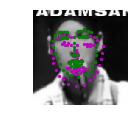

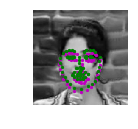

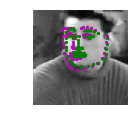

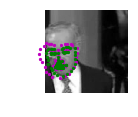

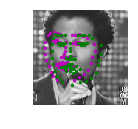

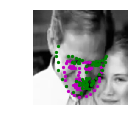

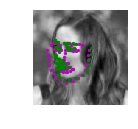

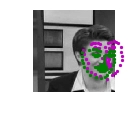

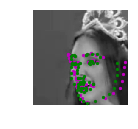

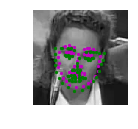

In [18]:
## TODO: visualize your test output you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

So I used MSELoss, as it was one of the suggestions in this notebook for measuring logistic regretion loss. I also used an Adam optimizor as sugessted in [this](https://arxiv.org/pdf/1710.00977.pdf) paper. 

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 

I did some research and decided to use the architecture suggested in [this](https://arxiv.org/pdf/1710.00977.pdf) paper. This architecutre consists of 4 convolutional networks with relu as activation function,  maxpooling by half and dropout after each convolutional layer. Then there are three linear layers, also with relu and dropout. The dropout probabilities were small in the first layers, the increased with each layer of the network.

The architecutre in the network is designed to work with each facial keypoint at a time, so the last linear layer has output of 2. I used this same network to learn to predict all 64 facial keypoints at the same time, modifiyng the last linear layer to have an input of 128. This network seem to do well in this case too. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 

I tried with batch size 20 and 40, but the system was running out of memory. I could have decreased the image size, but insted I decided to keep batch size at 10. I did not want to go lower than that to be able to keep the learning rate in proportion to the paramters sugested in the paper. (They used bach size 128, learing rate of 0.001, so I used batch size 10, and lr or 0.0001). I decided to run 20 epochs but the training was taking too long and the loss was still decreasing. I decided to use the GPU, and run for 100 epochs. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.23675749  0.06098971 -0.12839951 -0.06624849  0.0221147 ]
 [-0.08656296  0.05752258 -0.01759861 -0.07250181 -0.06053209]
 [ 0.21260141  0.14808436  0.10425086 -0.15911853  0.1331542 ]
 [-0.13325484 -0.05410387 -0.04014376 -0.01481952  0.03138125]
 [ 0.00825159 -0.09023747 -0.02462085 -0.19990906  0.04480911]]
(5, 5)


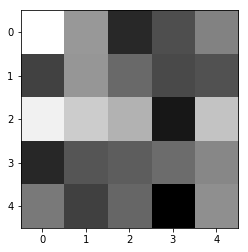

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
## TODO: Define the Net in models.py
import torch
from models import Net
import matplotlib.pyplot as plt

net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model.pt'))
net.eval()

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


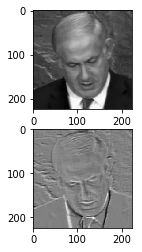

In [21]:
##TODO: load in and display any image from the transformed test dataset
import cv2
test_images, _, _ = net_sample_output()
n = np.random.randint(batch_size)
if train_on_gpu:
    test_images = test_images.detach().cpu().numpy()
else:
    test_images = test_images.numpy()
image = np.squeeze(test_images[n])


## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
f = 2
c = cv2.filter2D(image,-1,w[f-1][0])


plt.subplot(2, 1, 1)
plt.imshow(image,cmap="gray")

plt.subplot(2, 1, 2)
plt.imshow(c,cmap="gray")

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I chose the second filter of the first conv layer and it seems to blur the image. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!